In [1]:
# imports
import os
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from google.colab import drive # Модуль для работы с Google Disk
from PIL import Image

In [2]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NOISE_FACTOR = 0.25

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [4]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

In [5]:
# the autoencoder network
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [6]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [7]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # we do not need the image labels
            # add noise to the image data
            img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
            # clip to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)
            img = np.clip(img,0.,1.)

            img_noisy = img_noisy.to(device)
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img_noisy)
            loss = criterion(outputs, img_noisy)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(img_noisy.cpu().data, name='./Saved_Images/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised{}.png'.format(epoch))
    return train_loss

In [14]:
def test_image_reconstruction(net, testset):
    img = torch.zeros([10,1,28,28],dtype=torch.float64)
    class_nums = [i for i in range(0,10)]
    for sample in list(testset):
        if sample[1] in class_nums:
            img[sample[1]] = torch.Tensor(sample[0])
            class_nums.remove(sample[1])
    img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    img = np.clip(img, 0., 1.)

    img_noisy = img_noisy.cuda().float()
    # im = transforms.ToPILImage()(img_noisy[1])

    # return im
    outputs = net(img_noisy)
    # print(outputs.size(0))
    outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    save_image(img_noisy, 'noisy_test_input_FMNIST.png',nrow=5)
    save_image(outputs, 'denoised_test_reconstruction_FMNIST.png',nrow=5)
    save_image(img, 'orig_FMNIST.png',nrow=5)

cuda:0
Epoch 1 of 5, Train Loss: 0.041
Epoch 2 of 5, Train Loss: 0.035
Epoch 3 of 5, Train Loss: 0.034
Epoch 4 of 5, Train Loss: 0.033
Epoch 5 of 5, Train Loss: 0.033


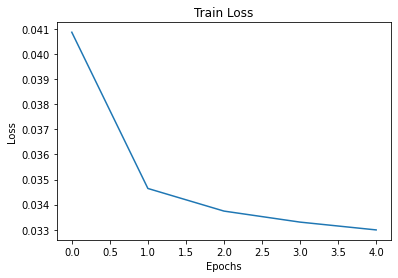

In [9]:
device = get_device()
print(device)
net.to(device)
make_dir()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Saved_Images/conv_ae_fahsionmnist_loss.png')

In [10]:
drive.mount('/content/drive')
torch.save(net.state_dict(),'/content/drive/My Drive/Colab Notebooks/Models/AutoEncoderFMNIST.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


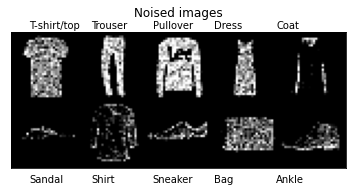

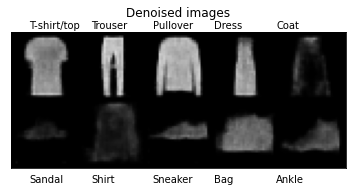

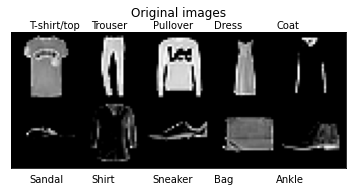

In [15]:
def text(class_list):
    for i in range(2):
        for j in range(5):
            plt.text(j*28+8,i*70-2,class_list[i][j])

def show_img(img):
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    text(class_list)
    plt.show()


netFMNIST = Autoencoder().cuda()
FMNIST = torch.load('/content/drive/My Drive/Colab Notebooks/Models/AutoEncoderFMNIST.pth')
netFMNIST.load_state_dict(FMNIST)

class_list = ['T-shirt/top Trouser Pullover Dress Coat'.split(' '), 'Sandal Shirt Sneaker Bag Ankle boot'.split(' ')]

test_image_reconstruction(netFMNIST, testset)
img_noisy=plt.imread('noisy_test_input_FMNIST.png')
img_output = plt.imread('denoised_test_reconstruction_FMNIST.png')
img_orig = plt.imread('orig_FMNIST.png')

plt.title('Noised images',pad=15)
show_img(img_noisy)
plt.title('Denoised images',pad=15)
show_img(img_output)
plt.title('Original images',pad=15)
show_img(img_orig)